SMS Spam Detection Using NLP

In [2]:
#importing libreries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix


In [3]:
#read the dataset
data  = pd.read_csv('spam.csv')

In [4]:
#view top 5 records
data.head()

,class,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
#view last 5 records
data.tail()

,class,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will �_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [6]:
#view random 5 records from dataset
data.sample(5)

,class,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
340,ham,Ok that's great thanx a lot.,NaN,NaN,NaN
4377,ham,"Doing nothing, then u not having dinner w us?",NaN,NaN,NaN
1618,ham,The 2 oz guy is being kinda flaky but one frie...,NaN,NaN,NaN
219,ham,Yeah you should. I think you can use your gt a...,NaN,NaN,NaN
2387,ham,Also where's the piece,NaN,NaN,NaN


In [7]:
data.shape

(5572, 5)

Data Cleaning

In [8]:
#check info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class       5572 non-null   object
 1   message     5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [9]:
#drop the unwanted attributes
data.drop(columns={'Unnamed: 2','Unnamed: 3','Unnamed: 4'},inplace=True)

In [10]:
#rename attributes
data.rename(columns={"class":"result","message":"input"},inplace=True)

In [11]:
#convert from categorical to numerical
#convert from spam and ham to 1 and 0
encoder = LabelEncoder()
data['result'] = encoder.fit_transform(data['result'])

#display edited dataframe
data.head()

,result,input
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
data['result'].value_counts()

0    4825
1     747
Name: result, dtype: int64

In [13]:
#check for null values
data.isnull().sum()

result    0
input     0
dtype: int64

In [14]:
#check for duplicates count
data.duplicated().sum()

403

In [15]:
#remove duplicates
data = data.drop_duplicates(keep='first')

In [16]:
#check if duplicates are removed
data.duplicated().sum() 

0

EDA - Exploratory Data Analytics

In [17]:
data['result'].value_counts()

0    4516
1     653
Name: result, dtype: int64

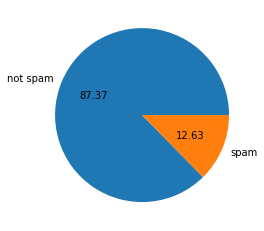

In [18]:
#plot a pie chart
plt.pie(data['result'].value_counts(),labels=['not spam','spam'],autopct='%0.2f')
plt.show()

In [19]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shrir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
#creating a new column with count of characters
data['countCharacters'] = data['input'].apply(len)

#creating a new column with count of words
data['countWords'] = data['input'].apply(lambda i:len(nltk.word_tokenize(i)))
#'word_tokenize' function takes a string of text as input and returns a list of words

#creating a new column with count of sentences
data['countSentences'] = data['input'].apply(lambda i:len(nltk.sent_tokenize(i)))
#'sent tokenize' function takes a string of text as input and returns a list of sentences



In [22]:
data.head()

,result,input,countCharacters,countWords,countSentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [23]:
#extracting the 5 number summary of the 3 new column values
data[['countCharacters','countWords','countSentences']].describe()

,countCharacters,countWords,countSentences
count,5169.000000,5169.000000,5169.000000
mean,78.924163,18.456761,1.966531
std,58.175349,13.325633,1.449833
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [24]:
#for not SPAM
data[data['result'] == 0][['countCharacters','countWords','countSentences']].describe()

,countCharacters,countWords,countSentences
count,4516.000000,4516.000000,4516.000000
mean,70.457263,17.123782,1.820195
std,56.357463,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [25]:
#for SPAM
data[data['result'] == 1][['countCharacters','countWords','countSentences']].describe()

,countCharacters,countWords,countSentences
count,653.000000,653.000000,653.000000
mean,137.479326,27.675345,2.978560
std,30.014336,7.011513,1.493185
min,13.000000,2.000000,1.000000
25%,131.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


<AxesSubplot:xlabel='countCharacters', ylabel='Count'>

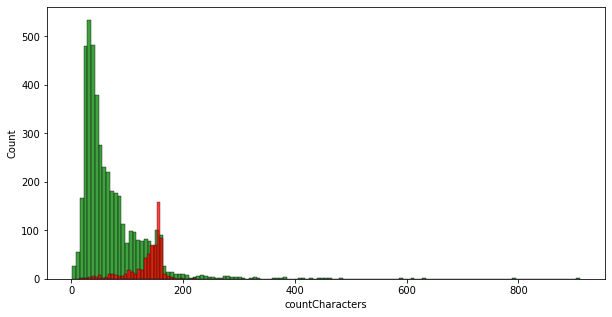

In [26]:
#ploting a histogram using seaborn
plt.figure(figsize=(10,5))
sns.histplot(data[data['result'] == 0]['countCharacters'],color="green")
sns.histplot(data[data['result'] == 1]['countCharacters'],color="red")
# red = SPAM green = NOT SPAM

<AxesSubplot:xlabel='countWords', ylabel='Count'>

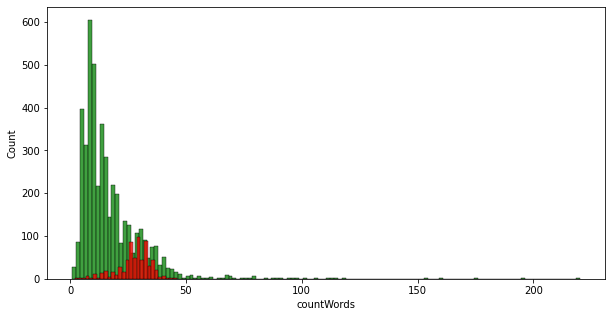

In [27]:
plt.figure(figsize=(10,5))
sns.histplot(data[data['result'] == 0]['countWords'],color="green")
sns.histplot(data[data['result'] == 1]['countWords'],color="red")
# red = SPAM green = NOT SPAM

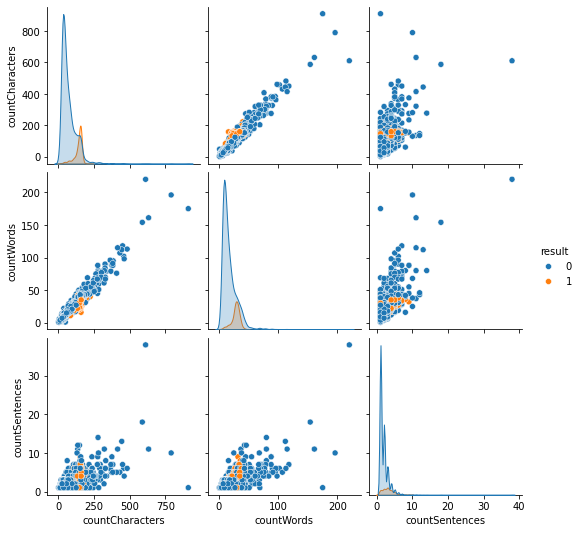

In [28]:
#finding relationship between the columns
sns.pairplot(data=data,hue='result')

Data Preprocessing

In [29]:
#performing preprocessing such as tokenization (converting text into tokens/words) etc
#removing stopwords and punctuations
#first convert to lower case and then pre-processing the data

In [30]:
#download stopwords
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
#function to clear stopwords and make everything lower case
stopwords = stopwords.words('English')
def transform_text(text):
    useFulWords = []
    text = text.lower()
    words = nltk.word_tokenize(text)
    for word in words:
        if word not in stopwords:
            useFulWords.append(word) 
            
    ps = PorterStemmer()
    stemmedUsefulWords = list()
    for i in useFulWords:
        stemmedUsefulWords.append(ps.stem(i))
    useFulWords = stemmedUsefulWords[:]
    return " ".join(useFulWords)

In [32]:
#will create a new column to store processed 
data['processed'] = data['input'].apply(transform_text)

#display the edited dataframe with a new column 'processed'
data.head()

,result,input,countCharacters,countWords,countSentences,processed
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,"go jurong point , crazi .. avail bugi n great ..."
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar ... joke wif u oni ...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor ... u c alreadi say ...
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,"nah n't think goe usf , live around though"


In [33]:
# we will create a word list for data visualization to display the most frequently occuring words
#using 'WordCloud' class

wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')


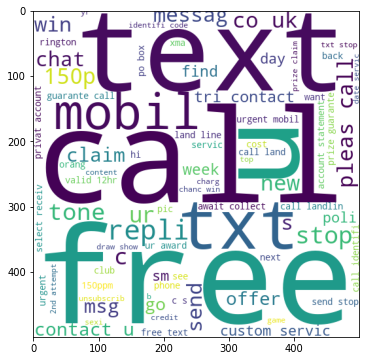

In [34]:
#creating a wordcloud for the SPAM messages
spamWC = wc.generate(data[data['result'] == 1]['processed'].str.cat(sep=" "))

#creating figure and displying
plt.figure(figsize=(12,6))
plt.imshow(spamWC)

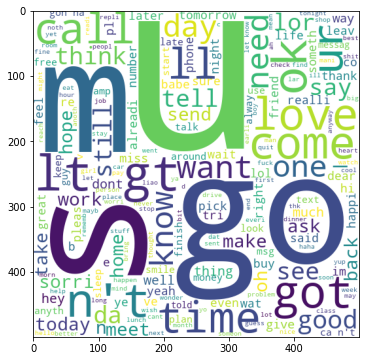

In [35]:
#creating a wordcloud for the NOT SPAM messages
spamWC = wc.generate(data[data['result'] == 0]['processed'].str.cat(sep=" "))

#creating figure and displying
plt.figure(figsize=(12,6))
plt.imshow(spamWC)

In [36]:
#extracting all the words used in SPAM messages
spamWords = list()

for msg in data[data['result'] == 1]['processed'].tolist():
    for word in msg.split():
        spamWords.append(word)

spamWords

['free',
 'entri',
 '2',
 'wkli',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkt',
 '21st',
 'may',
 '2005.',
 'text',
 'fa',
 '87121',
 'receiv',
 'entri',
 'question',
 '(',
 'std',
 'txt',
 'rate',
 ')',
 '&',
 'c',
 "'s",
 'appli',
 '08452810075over18',
 "'s",
 'freemsg',
 'hey',
 'darl',
 "'s",
 '3',
 'week',
 "'s",
 'word',
 'back',
 '!',
 "'d",
 'like',
 'fun',
 'still',
 '?',
 'tb',
 'ok',
 '!',
 'xxx',
 'std',
 'chg',
 'send',
 ',',
 '�1.50',
 'rcv',
 'winner',
 '!',
 '!',
 'valu',
 'network',
 'custom',
 'select',
 'receivea',
 '�900',
 'prize',
 'reward',
 '!',
 'claim',
 'call',
 '09061701461.',
 'claim',
 'code',
 'kl341',
 '.',
 'valid',
 '12',
 'hour',
 '.',
 'mobil',
 '11',
 'month',
 '?',
 'u',
 'r',
 'entitl',
 'updat',
 'latest',
 'colour',
 'mobil',
 'camera',
 'free',
 '!',
 'call',
 'mobil',
 'updat',
 'co',
 'free',
 '08002986030',
 'six',
 'chanc',
 'win',
 'cash',
 '!',
 '100',
 '20,000',
 'pound',
 'txt',
 '>',
 'csh11',
 'send',
 '87575.',
 'cost',
 '150p/da

In [37]:
#to count the frequency of these words, we will be usng the counter class to create a dictionary
spamWordsDictionary = Counter(spamWords)

#to get the most common words used
spamWordsDictionary.most_common(40)

[('.', 780),
 ('!', 453),
 ('call', 320),
 (',', 301),
 ('free', 191),
 ('&', 160),
 ('?', 159),
 ('2', 155),
 (':', 150),
 ('txt', 141),
 ('text', 122),
 ('u', 119),
 ('ur', 119),
 ('mobil', 114),
 ('*', 108),
 ('stop', 104),
 ('repli', 103),
 ('claim', 98),
 ('4', 97),
 ('prize', 82),
 ('get', 74),
 ('new', 64),
 ('servic', 64),
 ('tone', 63),
 ('send', 60),
 ("'s", 59),
 ('urgent', 57),
 ('nokia', 57),
 ('contact', 56),
 (')', 55),
 ('award', 55),
 ('phone', 52),
 ('cash', 51),
 ('pleas', 51),
 ('-', 50),
 ('week', 49),
 ('win', 48),
 ('(', 46),
 ('c', 45),
 ('collect', 45)]

In [38]:
#converting this dictionary to a dataframe
mostCommonSPAM = pd.DataFrame(spamWordsDictionary.most_common(40))

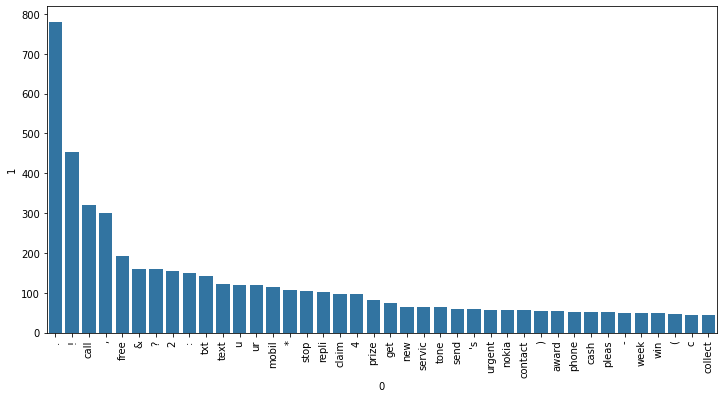

In [39]:
#ploting a bar point of the mostCommonSPAM dataframe
plt.figure(figsize=(12,6))
sns.barplot(data=mostCommonSPAM,x=0,y=1)
plt.xticks(rotation='vertical')
plt.show()

Model Building

In [40]:
#Naive Bayes classifier works best on text data
#before training the model convert text to numerical data

In [41]:
#converting the text to matrix of token counts
cv = CountVectorizer()

In [44]:
#transforming the data
X = cv.fit_transform(data['processed']).toarray()

#print sizeof array
X.shape

(5169, 7334)

In [46]:
#storing the values of the 'result' column
y = data['result'].values
y

array([0, 0, 1, ..., 0, 0, 0])

In [47]:
#splitting data for training and testing the model
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=49)

In [51]:
#creating models objects
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [54]:
#training data for GaussianNB
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8655705996131529
[[776 123]
 [ 16 119]]
0.49173553719008267


In [55]:
#training data for MultinomialNB
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.97678916827853
[[884  15]
 [  9 126]]
0.8936170212765957


In [56]:
#training data for BernouliNB
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9671179883945842
[[891   8]
 [ 26 109]]
0.9316239316239316


In [57]:
#using 'TfidfVectorizer' for vectorization
tf = TfidfVectorizer()

#transforming the data
X = tf.fit_transform(data['processed']).toarray()

#storing the values of the 'result' column
y = data['result'].values

#splitting the data 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=49)

In [58]:
#training data for GaussianNB
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8636363636363636
[[777 122]
 [ 19 116]]
0.48739495798319327


In [59]:
#training data for MultinomialNB
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9593810444874274
[[899   0]
 [ 42  93]]
1.0


In [60]:
#training data for BernouliNB
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9671179883945842
[[891   8]
 [ 26 109]]
0.9316239316239316


In [65]:
#model is prepared now.
#pipeling is required for the website
#pickle the files

import pickle
pickle.dump(tf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))